In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import torch

#load functions from files
import shot_detection.shot_boundary_functions as sb
import shot_detection.preprocessing_functions as pre
import shot_detection.summarization_functions as summ

In [18]:
BOUNDARY_FILE = 'shot_detection/rgb_frames/comp_frames/boundary-frame.png'
REPORTER_FILE = 'shot_detection/rgb_frames/comp_frames/news-reporter.png'
END_LOGO_FILE = 'shot_detection/rgb_frames/comp_frames/end-logo.png'

NEWS_VIDEOS1 = ['august-07-2018', 'april-27-2018', 'april-12-2018'] #'april-11-2018', 'april-08-2018']
NEWS_VIDEOS2 = ['june-05-2018', 'february-25-2018', 'august-30-2018', 'august-25-2018']
NEWS_VIDEOS3 = ['september-25-2018', 'september-24-2018', 'september-19-2018', 'september-18-2018'] 
NEWS_VIDEOS4 = ['september-17-2018', 'september-16-2018', 'september-13-2018', 'september-12-2018']
NEWS_VIDEOS5 = ['september-03-2018', 'september-01-2018', 'june-25-2018', 'june-18-2018']

NEWS_VIDEOS = [['april-11-2018'], NEWS_VIDEOS1, NEWS_VIDEOS2, NEWS_VIDEOS3, NEWS_VIDEOS4, NEWS_VIDEOS5]
# 'april-21-2018' first news story is empty?
# 'april-26-2018',

ROOT_PATH = '../data/'

def init_summarization(method, boundary, video_name):
    #!/usr/bin/env python

    # Map command line arguments to function arguments.
    TEST_DATA = video_name
    image_tmpl = 'image-{:03d}.png'
    
    
    directory = ROOT_PATH + video_name + '/'

    #load and process news video frames
    if method == 'alexnet':
        color = 'tensor'
        frs_amount, frs_list = pre.frames_to_tensor(directory, image_tmpl, 'all')
        method_list = sb.get_alexnet_features(frs_list)
    elif method == 'histogram':
        color = 'RGB'
        frs_amount, frs_list = pre.frames_to_float(directory, image_tmpl, color)
        method_list = sb.make_histlist(frs_list)
    elif method == 'pixel':
        color = 'LA'
        frs_amount, method_list = pre.frames_to_float(directory, image_tmpl, color)
    print(frs_amount)
    
    return method_list, frs_amount

def test_summarization(method, boundary, video_name, method_list, frs_amount):
    
    if method == 'alexnet':
        color = 'tensor'
        k = -1
        k_end = -2.2
        reporter_torch = pre.process_single_fr(REPORTER_FILE, color) #load reporter boundary frame
        reporter_method = sb.get_alexnet_features([reporter_torch])[0]
        end_logo_torch = pre.process_single_fr(END_LOGO_FILE, color) #load end logo boundary frame
        end_logo_method = sb.get_alexnet_features([end_logo_torch])[0]
        comp_torch = pre.process_single_fr(BOUNDARY_FILE, color) #load comparison frame
        comp_method = sb.get_alexnet_features([comp_torch])[0]
    elif method == 'histogram':
        color = 'RGB'
        k = -1.2
        k_end = -2.7
        reporter_rgb = pre.process_single_fr(REPORTER_FILE, color) #load reporter boundary frame
        reporter_method = plt.hist(reporter_rgb.flatten(), 100)
        end_logo_rgb = pre.process_single_fr(END_LOGO_FILE, color) #load end logo boundary frame
        end_logo_method = plt.hist(end_logo_rgb.flatten(), 100)
        comp_rgb = pre.process_single_fr(BOUNDARY_FILE, color) #load comparison frame
        comp_method = plt.hist(comp_rgb.flatten(), 100)
        plt.close()
    elif method == 'pixel':
        color = 'LA'
        k = -1.5
        k_end = -2.4
        reporter_method = pre.process_single_fr(REPORTER_FILE, color) #load reporter boundary frame
        end_logo_method = pre.process_single_fr(END_LOGO_FILE, color) #load end logo boundary frame
        comp_method = pre.process_single_fr(BOUNDARY_FILE, color) #load comparison frame
    
    
    # shorten video - start (reporter comparison)
    sim_frames_reporter, reporter_diff, reporter_tcut = sb.compare_frs(method_list[0:150], reporter_method, method, k)
    print('Amount of Similar Frames: ', len(sim_frames_reporter))
    
    #plot difference reporter
    plt.plot(reporter_diff)
    plt.title('Frame Difference with Detected Cut : Reporter')
    plt.xlabel('Frames')
    plt.axhline(reporter_tcut, color='black', lw=1)
    plt.ylabel('Difference')
    plt.show()    
    
    print(sim_frames_reporter[-1][0])
    reporter_boundarynr = sim_frames_reporter[-1][0] + 1
    print('reporter_boundarynr', reporter_boundarynr)
    


    # shorten video - end (end_logo comparison)
    sim_frames_endlogo, endlogo_diff, endlogo_tcut = sb.compare_frs(method_list[reporter_boundarynr::], end_logo_method, method, k_end)
    end_logo_boundarynr = sim_frames_endlogo[0][0]
    print("reporter boundary: ", reporter_boundarynr, "\nstart of end logo: ", end_logo_boundarynr)
    method_list = method_list[reporter_boundarynr:end_logo_boundarynr]

    #plot difference reporter
    plt.plot(endlogo_diff)
    plt.title('Frame Difference with Detected Cut : Endlogo')
    plt.xlabel('Frames')
    plt.axhline(endlogo_tcut, color='black', lw=1)
    plt.ylabel('Difference')
    plt.show()
    
    #shot boundary detection
    sim_frames, fr_diff, t_cut_value = sb.compare_frs(method_list, comp_method, method, k)
    boundaries, boundary_nrs = sb.improve_boundaries(sim_frames, method_list)
    fragments_frs_list = sb.split_fr_list(method_list, boundary_nrs) #fragment the method list

    print(boundary_nrs)
    #plot difference reporter
    plt.plot(fr_diff)
    plt.title('Frame Difference with Detected Cut : Boundaries')
    plt.xlabel('Frames')
    plt.axhline(t_cut_value, color='black', lw=1)
    plt.ylabel('Difference')
    plt.show()
    # print(fragments_frs_list)

    #summarize news fragments
    print('there are ', len(fragments_frs_list), 'news stories')
    differences, keyframes = summ.report_keyframes_fragments(fragments_frs_list, method, int(boundary))
#     print('differences keyframes: ', differences)
    print('keyframes1: ', keyframes)
    #plot difference reporter
    plt.plot(np.concatenate(differences[0::], axis=None))
#     plt.axhline(boundary, color='black', lw=1)
    plt.title('Frame Difference: keyframes')
    plt.xlabel('Frames')
    plt.ylabel('Difference')
    plt.show()
    fragments_keyframes = summ.keyfr_index_to_image(keyframes, boundary_nrs, reporter_boundarynr)
    print(video_name, '; ', fragments_keyframes)

    return boundary_nrs, fragments_keyframes, [fr_diff, t_cut_value], [reporter_diff, reporter_tcut, reporter_boundarynr], [endlogo_diff, endlogo_tcut], differences


# Test 1 - April 21

In [14]:
method_listpix, frs_amountpix = init_summarization('pixel', 38*10**6 ,'april-21-2018')

615


Amount of Similar Frames:  34


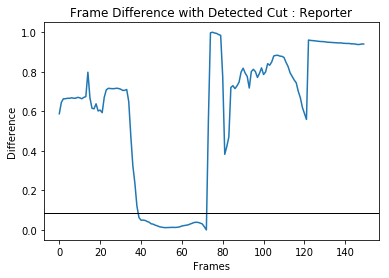

72
reporter_boundarynr 73
reporter boundary:  73 
start of end logo:  505


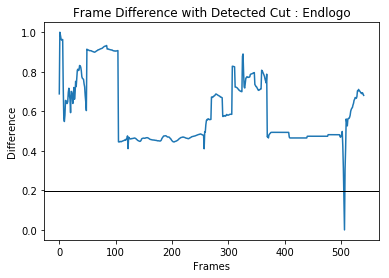

[0, 123, 258, 370, 431]


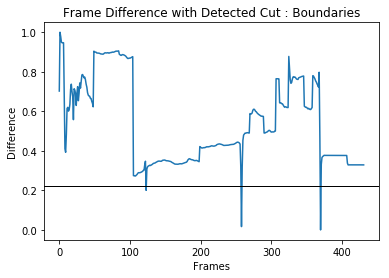

there are  4 news stories
keyframes1:  [[3, 7, 8, 11, 32, 46, 49, 105, 122], [3, 76], [3, 12, 32, 49, 54, 67, 70, 73, 89, 110, 111], [3]]


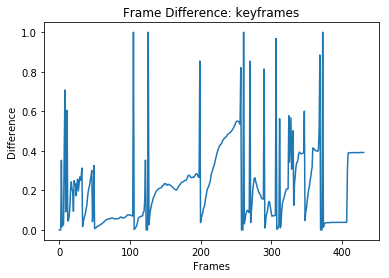

april-21-2018 ;  [[77, 81, 82, 85, 106, 120, 123, 179, 196], [200, 273], [335, 344, 364, 381, 386, 399, 402, 405, 421, 442, 443], [447]]


In [19]:
boundary_nrspix, fragments_keyframespix, fr_diffpix, reporterpix, endlogopix, differencespix = test_summarization('pixel', 38*10**6 ,'april-21-2018', method_listpix, frs_amountpix)

In [16]:
method_listnet, frs_amountnet = init_summarization('alexnet', 50,'april-21-2018')

614


Amount of Similar Frames:  36


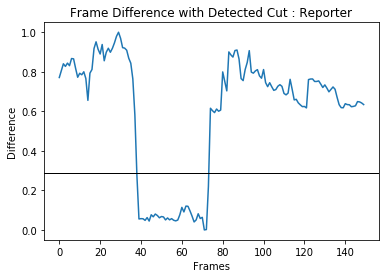

73
reporter_boundarynr 74
reporter boundary:  74 
start of end logo:  504


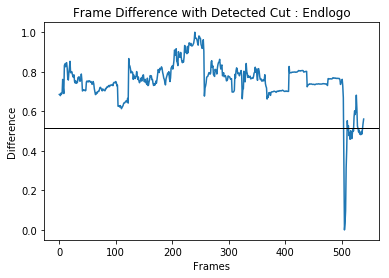

[0, 41, 257, 324, 366, 429]


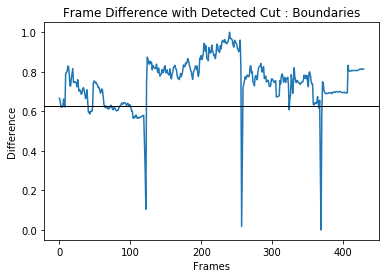

there are  5 news stories
keyframes1:  [[7, 17], [63, 80, 82, 83, 157, 197, 215], [3, 12, 39, 49, 54], [3, 11, 22, 34], [3, 4, 5, 41]]


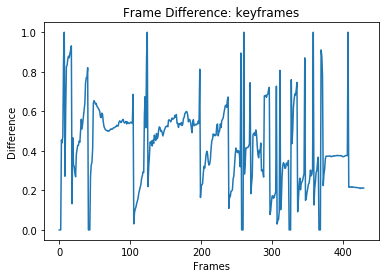

april-21-2018 ;  [[82, 92], [179, 196, 198, 199, 273, 313, 331], [335, 344, 371, 381, 386], [402, 410, 421, 433], [444, 445, 446, 482]]


In [17]:
boundary_nrsnet, fragments_keyframesnet, fr_diffnet, reporternet, endlogonet, differencesnet = test_summarization('alexnet', 50,'april-21-2018', method_listnet, frs_amountnet)

In [4]:
method_listhist, frs_amounthist = init_summarization('histogram', 78*10**4,'april-21-2018')

/usr/local/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


615


Amount of Similar Frames:  35


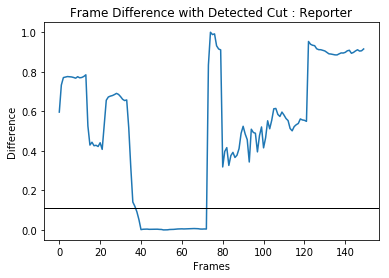

72
reporter_boundarynr 73
reporter boundary:  73 
start of end logo:  506


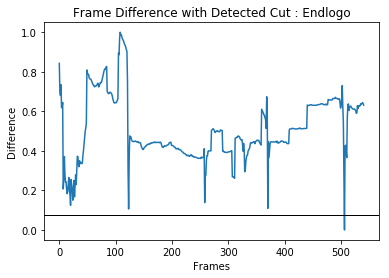

[0, 122, 258, 370, 432]


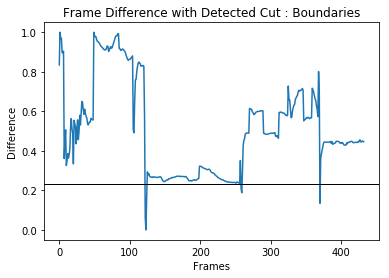

there are  4 news stories
keyframes1:  [[3, 7, 8, 11, 17, 45, 49, 105, 110, 121], [3, 135], [3, 12, 32, 49, 101, 110, 111], [3]]


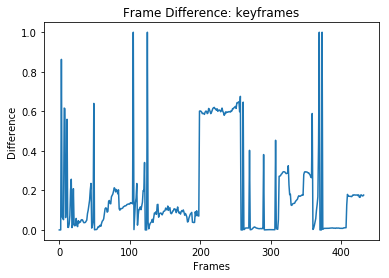

april-21-2018 ;  [[77, 81, 82, 85, 91, 119, 123, 179, 184, 195], [199, 331], [335, 344, 364, 381, 433, 442, 443], [447]]


In [13]:
boundary_nrshist, fragments_keyframeshist, fr_diffhist, reporterhist, endlogohist, differenceshist = test_summarization('histogram', 45*10**4,'april-21-2018', method_listhist, frs_amounthist)

### Visualize Results

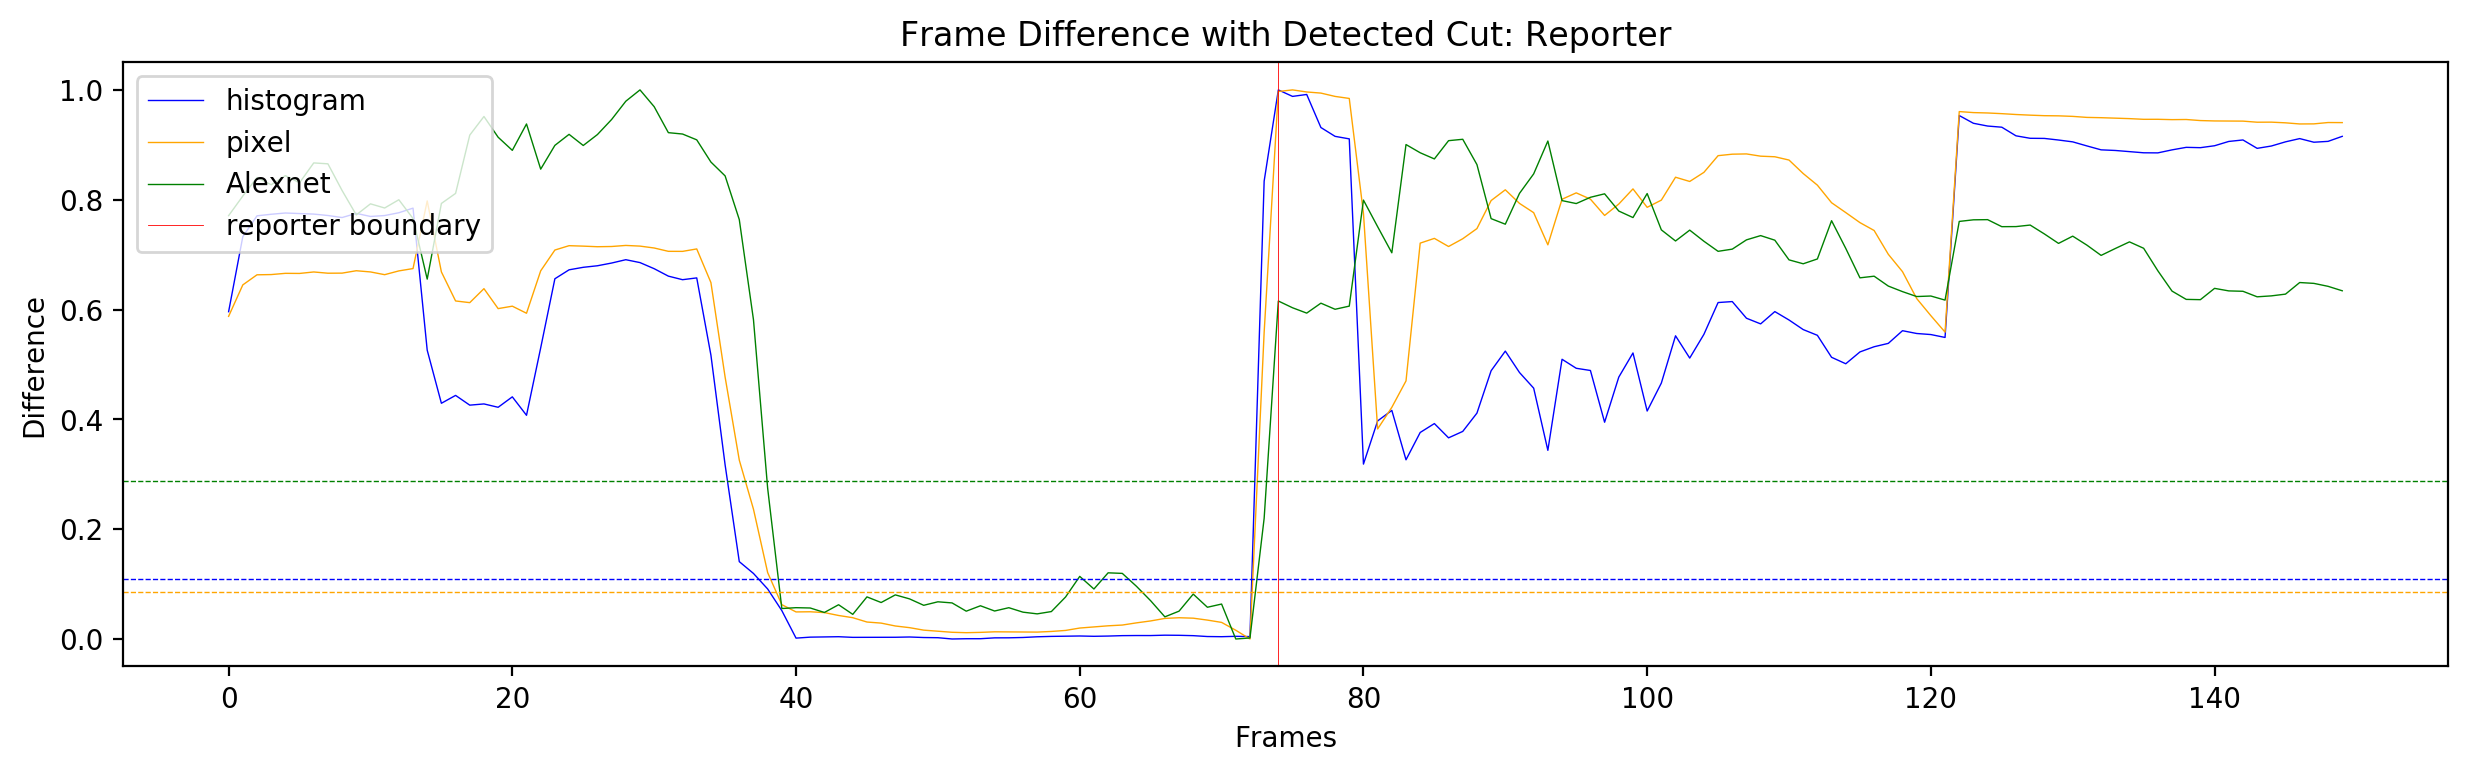

In [20]:
# reporterhist[0] = diff, reporterhist[1] = tcut
plt.figure(dpi =200, figsize=(15, 4))
plt.title('Frame Difference with Detected Cut: Reporter')
plt.xlabel('Frames')
plt.ylabel('Difference')

plt.plot(reporterhist[0], lw = 0.5, color = 'blue', label = 'histogram')
plt.plot(reporterpix[0], lw = 0.5, color = 'orange', label = 'pixel')
plt.plot(reporternet[0], lw = 0.5, color = 'green', label = 'Alexnet')

plt.axvline(74, lw = 0.3, color = 'red', label = 'reporter boundary')
plt.legend(loc='upper left')

plt.axhline(reporterhist[1], lw = 0.5, color = 'blue', ls = '--')
plt.axhline(reporterpix[1], lw = 0.5, color = 'orange', ls = '--')
plt.axhline(reporternet[1], lw = 0.5, color = 'green', ls = '--')

plt.savefig('april21-reporter-diff')
plt.show()

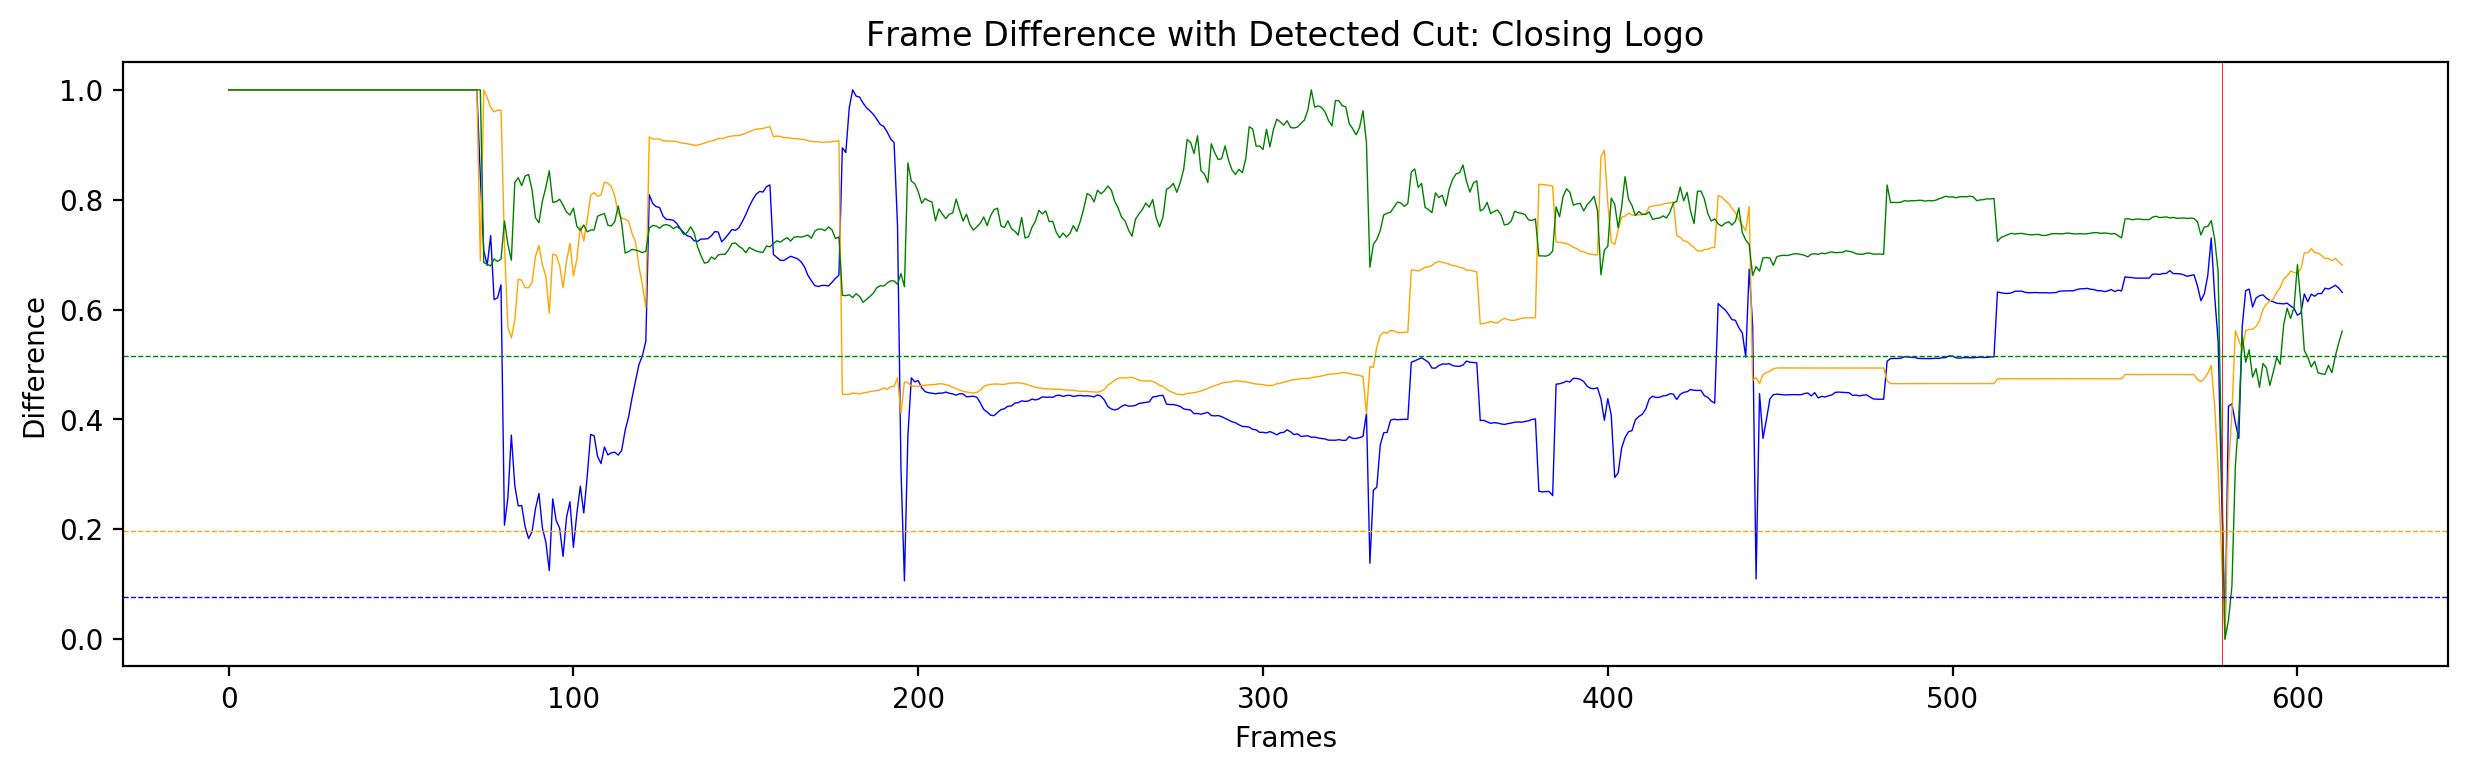

In [21]:
# reporterhist[0] = diff, reporterhist[1] = tcut
plt.figure(dpi =200, figsize=(15, 4))
plt.title('Frame Difference with Detected Cut: Closing Logo')
plt.xlabel('Frames')
plt.ylabel('Difference')

plt.plot(np.concatenate([np.ones(reporterhist[2]), endlogohist[0]]), lw = 0.5, color = 'blue', label = 'histogram')
plt.plot(np.concatenate([np.ones(reporterpix[2]), endlogopix[0]]), lw = 0.5, color = 'orange', label = 'pixel')
plt.plot(np.concatenate([np.ones(reporternet[2]), endlogonet[0]]), lw = 0.5, color = 'green', label = 'Alexnet')

plt.axvline(504+reporternet[2] , lw = 0.3, color = 'red', label = 'closing logo boundary')


plt.axhline(endlogohist[1], lw = 0.5, color = 'blue', ls = '--')
plt.axhline(endlogopix[1], lw = 0.5, color = 'orange', ls = '--')
plt.axhline(endlogonet[1], lw = 0.5, color = 'green', ls = '--')

plt.savefig('april21-endlogo-diff')
plt.show()

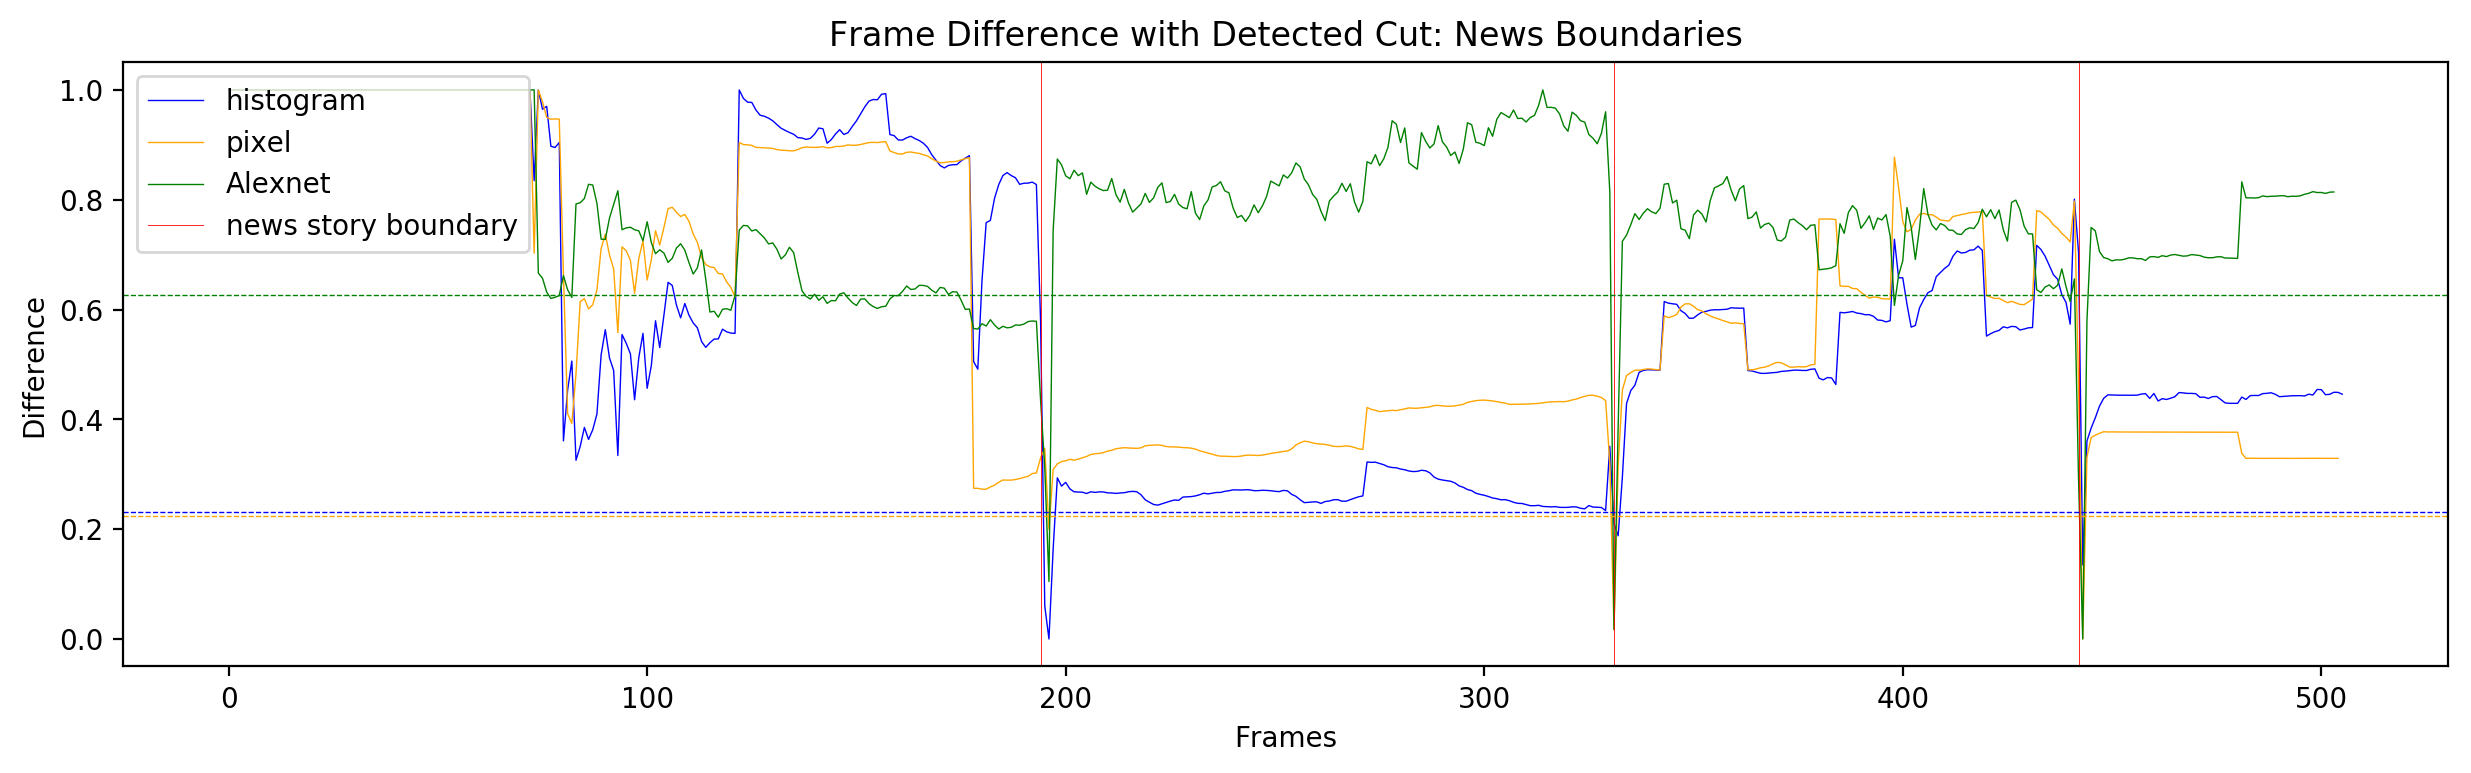

In [22]:
# reporterhist[0] = diff, reporterhist[1] = tcut
plt.figure(dpi =200, figsize=(15, 4))
plt.title('Frame Difference with Detected Cut: News Boundaries')
plt.xlabel('Frames')
plt.ylabel('Difference')

plt.plot(np.concatenate([np.ones(reporterhist[2]), fr_diffhist[0]]), lw = 0.5, color = 'blue', label = 'histogram')
plt.plot(np.concatenate([np.ones(reporterpix[2]), fr_diffpix[0]]), lw = 0.5, color = 'orange', label = 'pixel')
plt.plot(np.concatenate([np.ones(reporternet[2]), fr_diffnet[0]]), lw = 0.5, color = 'green', label = 'Alexnet')
plt.axvline(120+reporternet[2], lw = 0.3, color = 'red', label = 'news story boundary')
plt.legend(loc='upper left')

plt.axvline(257+reporternet[2], lw = 0.3, color = 'red')
plt.axvline(368+reporternet[2], lw = 0.3, color = 'red')
# plt.axvline(504, lw = 0.5, color = 'black', ls = '--', label = 'closing logo boundary')

plt.axhline(fr_diffhist[1], lw = 0.5, color = 'blue', ls = '--')
plt.axhline(fr_diffpix[1], lw = 0.5, color = 'orange', ls = '--')
plt.axhline(fr_diffnet[1], lw = 0.5, color = 'green', ls = '--')

plt.savefig('april21-boundaries-diff')
plt.show()

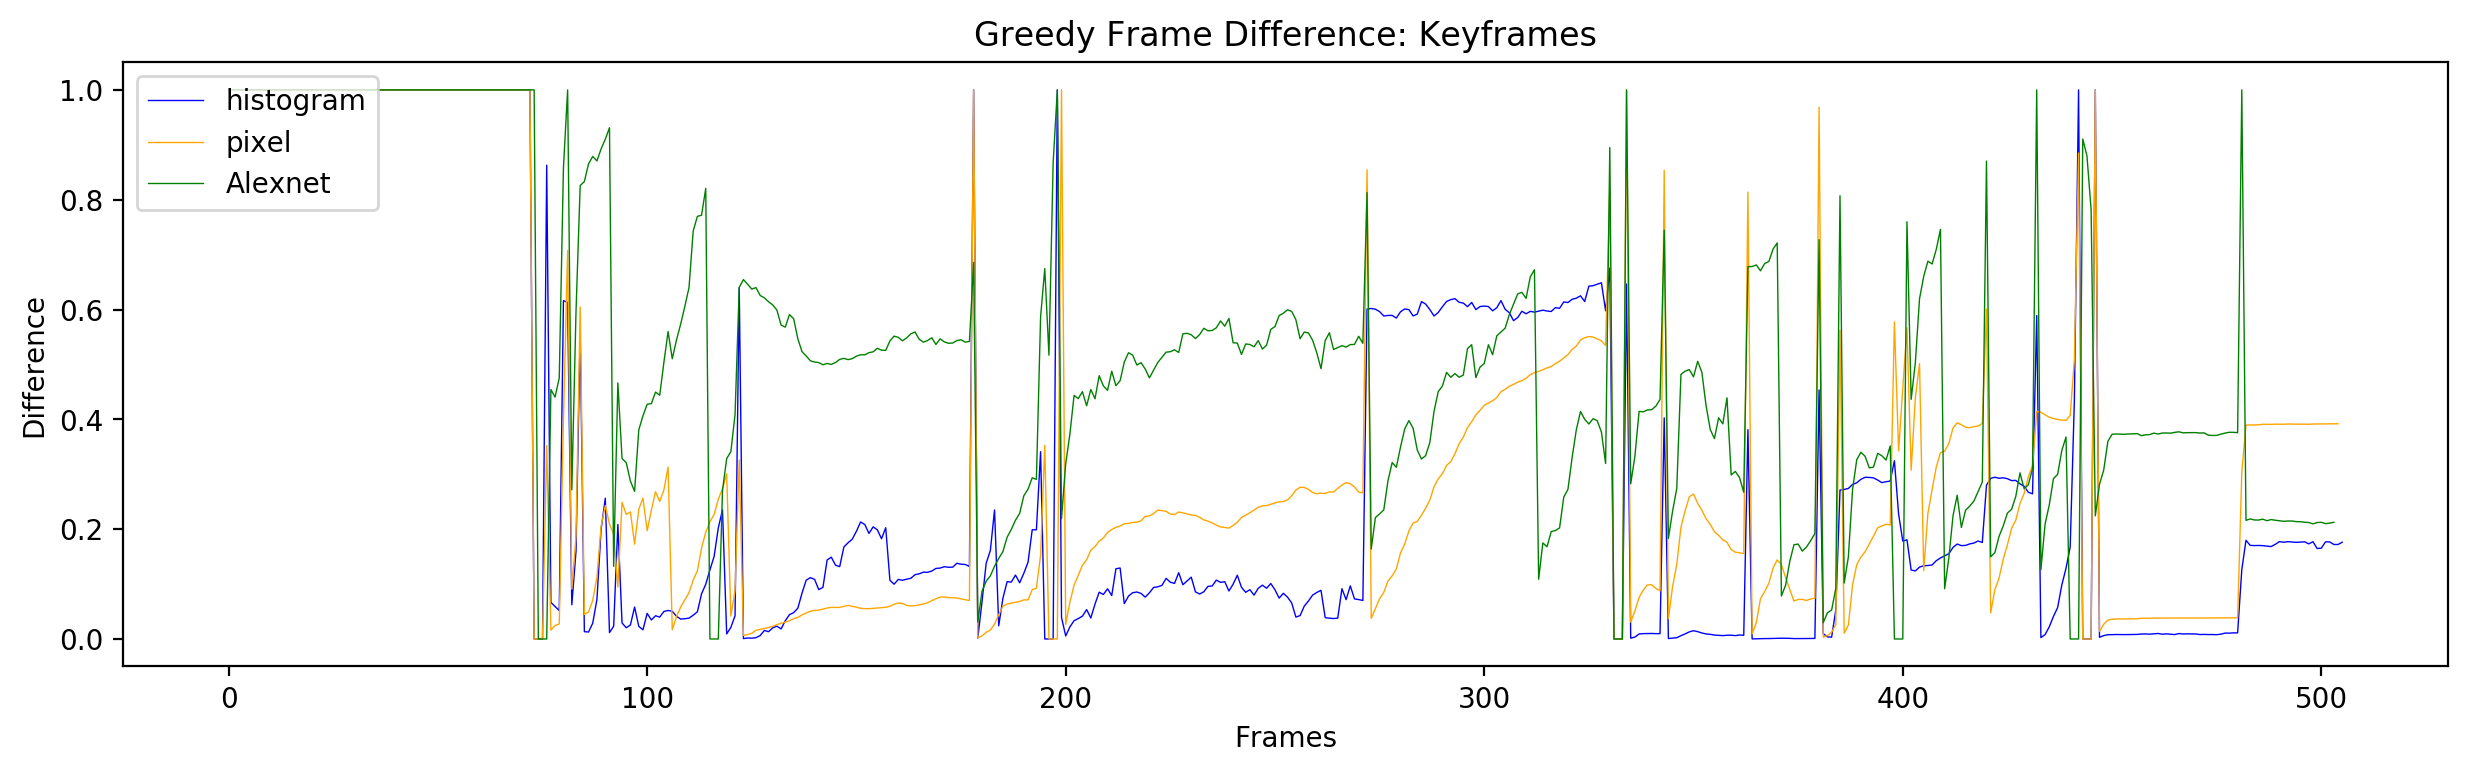

In [28]:
# keyframes = [74, 80, 122, 158, 178, 198, 272, 334, 343, 363, 380, 385, 398, 420, 431, 441, 445, 481, 513, 550]

# reporterhist[0] = diff, reporterhist[1] = tcut
plt.figure(dpi =200, figsize=(15, 4))
plt.title('Greedy Frame Difference: Keyframes')
plt.xlabel('Frames')
plt.ylabel('Difference')

plt.plot(np.concatenate([np.ones(reporterhist[2]), np.concatenate(differenceshist[0::], axis=None)]), lw = 0.5, color = 'blue', label = 'histogram')
plt.plot(np.concatenate([np.ones(reporterpix[2]), np.concatenate(differencespix[0::], axis=None)]), lw = 0.5, color = 'orange', label = 'pixel')
plt.plot(np.concatenate([np.ones(reporternet[2]), np.concatenate(differencesnet[0::], axis=None)]), lw = 0.5, color = 'green', label = 'Alexnet')
plt.legend(loc='upper left')

# plt.vlines(keyframes, 0, 1, lw = 0.3, color = 'red')


plt.savefig('april21-keyframe-diff')
plt.show()

# Test 2 - September 03

In [11]:
method_listpix2, frs_amountpix2 = init_summarization('pixel', 38*10**6 ,'september-16-2018')

573


Amount of Similar Frames:  31


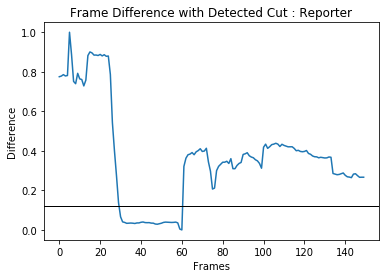

60
reporter_boundarynr 61
reporter boundary:  61 
start of end logo:  484


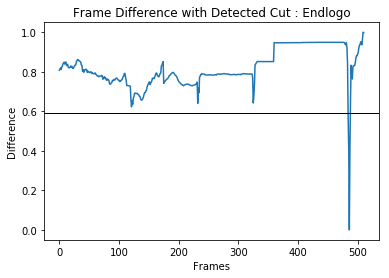

[0, 121, 233, 326, 422]


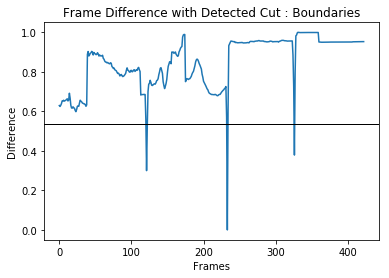

there are  4 news stories
keyframes1:  [[39, 120], [3, 26, 35, 54], [3, 92], [3]]


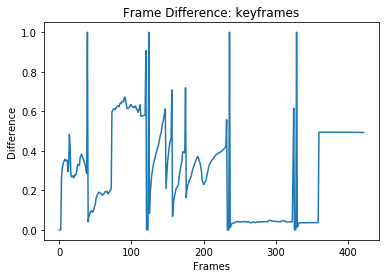

september-03-2018 ;  [[101, 182], [186, 209, 218, 237], [298, 387], [391]]


In [18]:
boundary_nrspix2, fragments_keyframespix2, fr_diffpix2, reporterpix2, endlogopix2, differencespix2 = test_summarization('pixel', 38*10**6 ,'september-03-2018', method_listpix2, frs_amountpix2)

In [3]:
method_listnet2, frs_amountnet2 = init_summarization('alexnet', 50, 'september-16-2018')

572


Amount of Similar Frames:  31


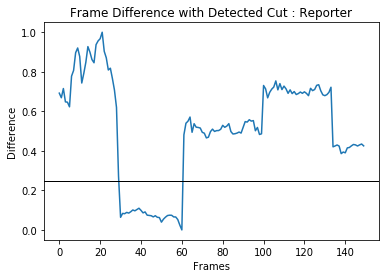

60
reporter_boundarynr 61
reporter boundary:  61 
start of end logo:  485


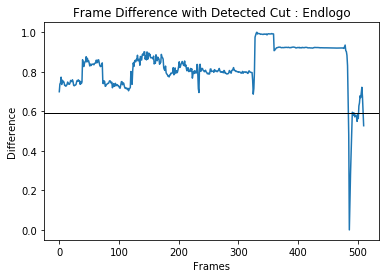

[0, 121, 233, 325, 423]


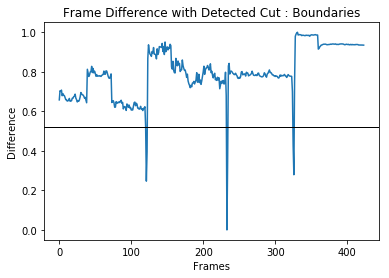

there are  4 news stories
keyframes1:  [[39, 73, 120], [3, 33, 35, 54, 111], [3, 91], [3, 35]]


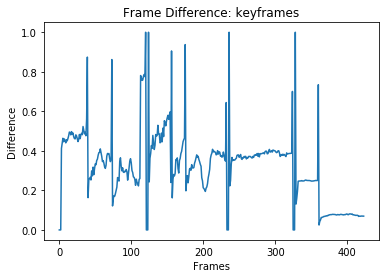

september-16-2018 ;  [[101, 135, 182], [186, 216, 218, 237, 294], [298, 386], [390, 422]]


In [7]:
boundary_nrsnet2, fragments_keyframesnet2, fr_diffnet2, reporternet2, endlogonet2, differencesnet2 = test_summarization('alexnet', 50,'september-16-2018', method_listnet2, frs_amountnet2)

In [8]:
method_listhist2, frs_amounthist2 = init_summarization('histogram', 78*10**4,'september-16-2018')

/usr/local/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


573


Amount of Similar Frames:  29


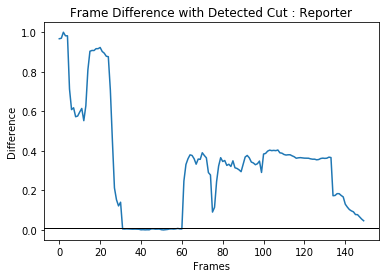

60
reporter_boundarynr 61
reporter boundary:  61 
start of end logo:  487


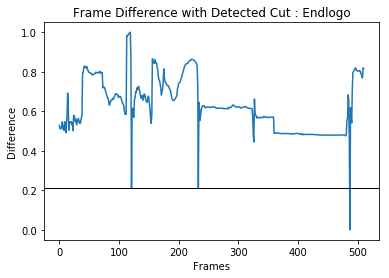

[0, 121, 425]


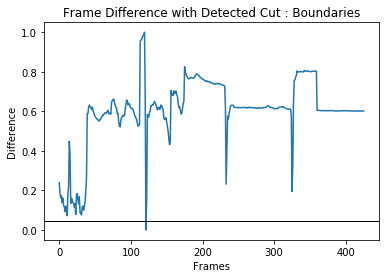

there are  2 news stories
keyframes1:  [[39, 113], [3, 52, 54, 112, 113, 114, 204, 206, 239]]


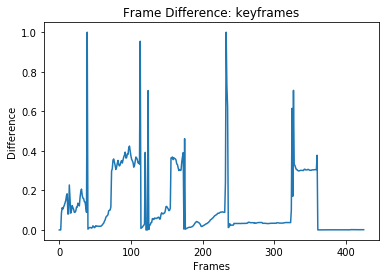

september-16-2018 ;  [[101, 175], [186, 235, 237, 295, 296, 297, 387, 389, 422]]


In [15]:
boundary_nrshist2, fragments_keyframeshist2, fr_diffhist2, reporterhist2, endlogohist2, differenceshist2 = test_summarization('histogram', 45*10**4,'september-16-2018', method_listhist2, frs_amounthist2)

### Visualise Results

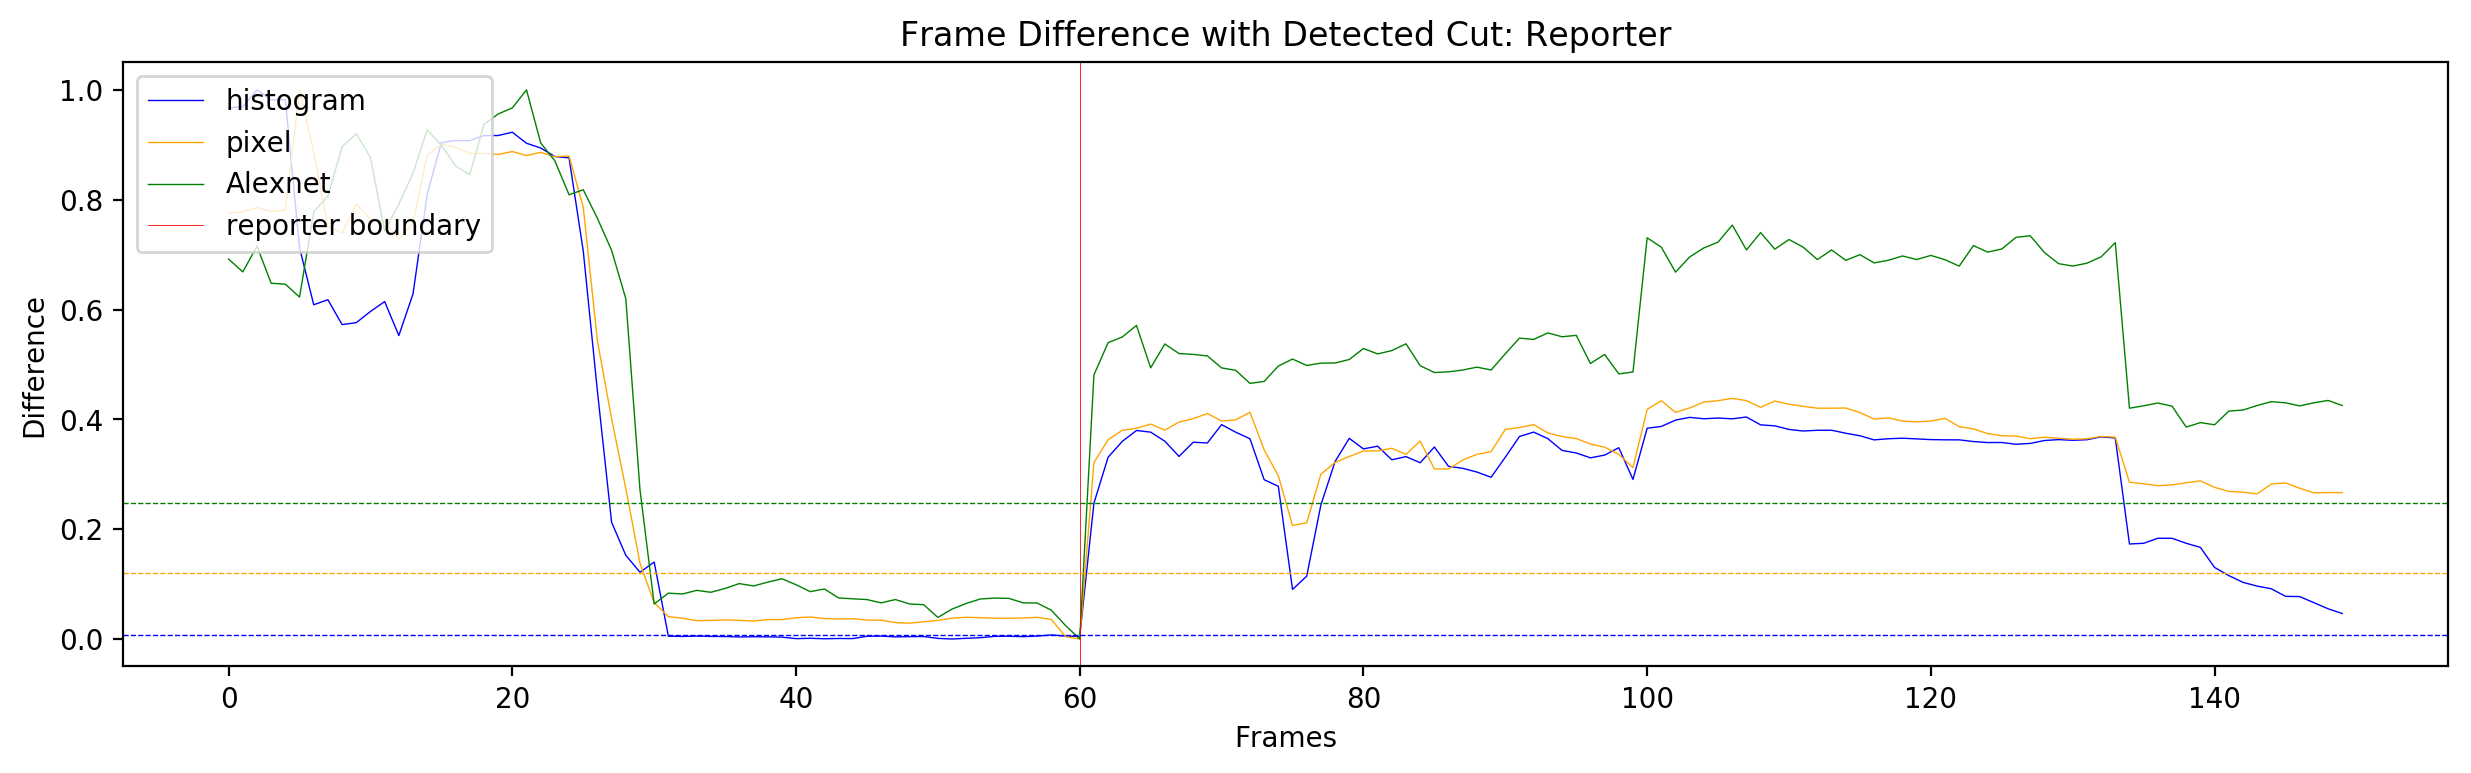

In [20]:
# reporterhist[0] = diff, reporterhist[1] = tcut
plt.figure(dpi =200, figsize=(15, 4))
plt.title('Frame Difference with Detected Cut: Reporter')
plt.xlabel('Frames')
plt.ylabel('Difference')

plt.plot(reporterhist2[0], lw = 0.5, color = 'blue', label = 'histogram')
plt.plot(reporterpix2[0], lw = 0.5, color = 'orange', label = 'pixel')
plt.plot(reporternet2[0], lw = 0.5, color = 'green', label = 'Alexnet')

plt.axvline(60, lw = 0.3, color = 'red', label = 'reporter boundary')
plt.legend(loc='upper left')

plt.axhline(reporterhist2[1], lw = 0.5, color = 'blue', ls = '--')
plt.axhline(reporterpix2[1], lw = 0.5, color = 'orange', ls = '--')
plt.axhline(reporternet2[1], lw = 0.5, color = 'green', ls = '--')

plt.savefig('sept03-reporter-diff')
plt.show()

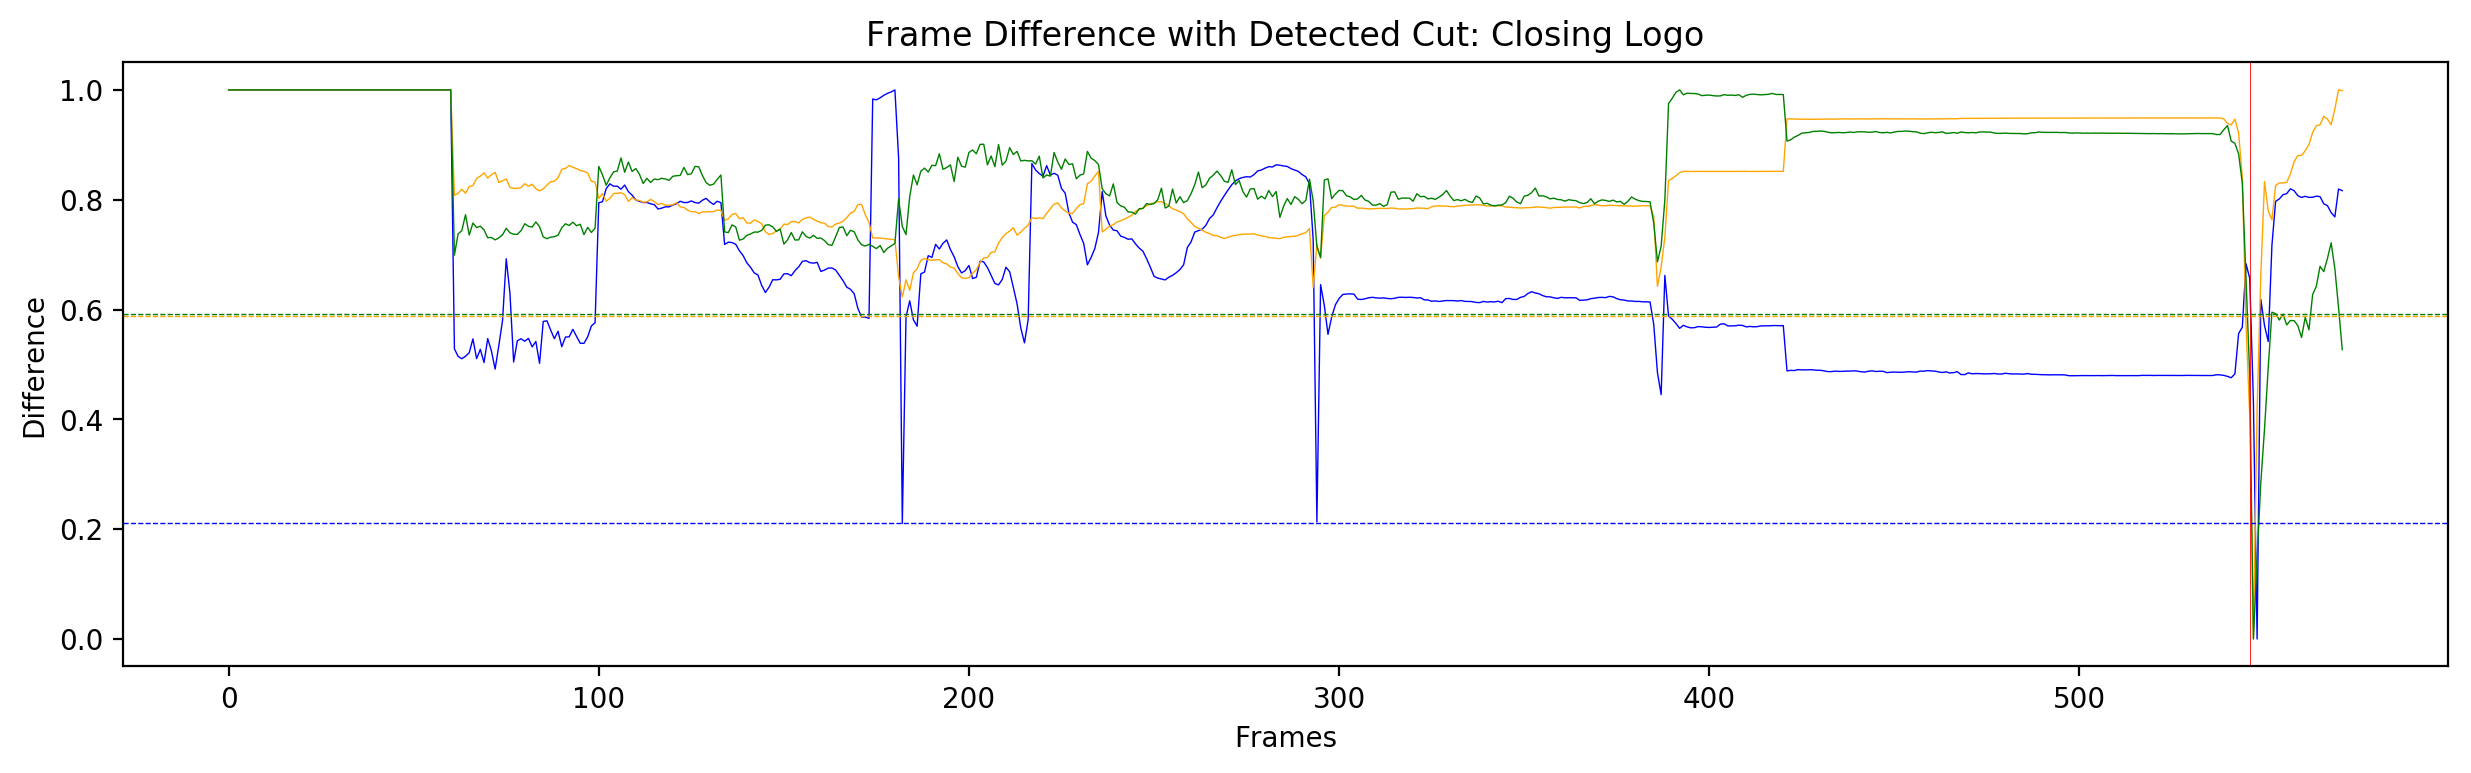

In [23]:
# reporterhist[0] = diff, reporterhist[1] = tcut
plt.figure(dpi =200, figsize=(15, 4))
plt.title('Frame Difference with Detected Cut: Closing Logo')
plt.xlabel('Frames')
plt.ylabel('Difference')

plt.plot(np.concatenate([np.ones(reporterhist2[2]), endlogohist2[0]]), lw = 0.5, color = 'blue', label = 'histogram')
plt.plot(np.concatenate([np.ones(reporterpix2[2]), endlogopix2[0]]), lw = 0.5, color = 'orange', label = 'pixel')
plt.plot(np.concatenate([np.ones(reporternet2[2]), endlogonet2[0]]), lw = 0.5, color = 'green', label = 'Alexnet')

plt.axvline(485+reporternet2[2] , lw = 0.3, color = 'red', label = 'closing logo boundary')


plt.axhline(endlogohist2[1], lw = 0.5, color = 'blue', ls = '--')
plt.axhline(endlogopix2[1], lw = 0.5, color = 'orange', ls = '--')
plt.axhline(endlogonet2[1], lw = 0.5, color = 'green', ls = '--')

plt.savefig('sept03-endlogo-diff')
plt.show()

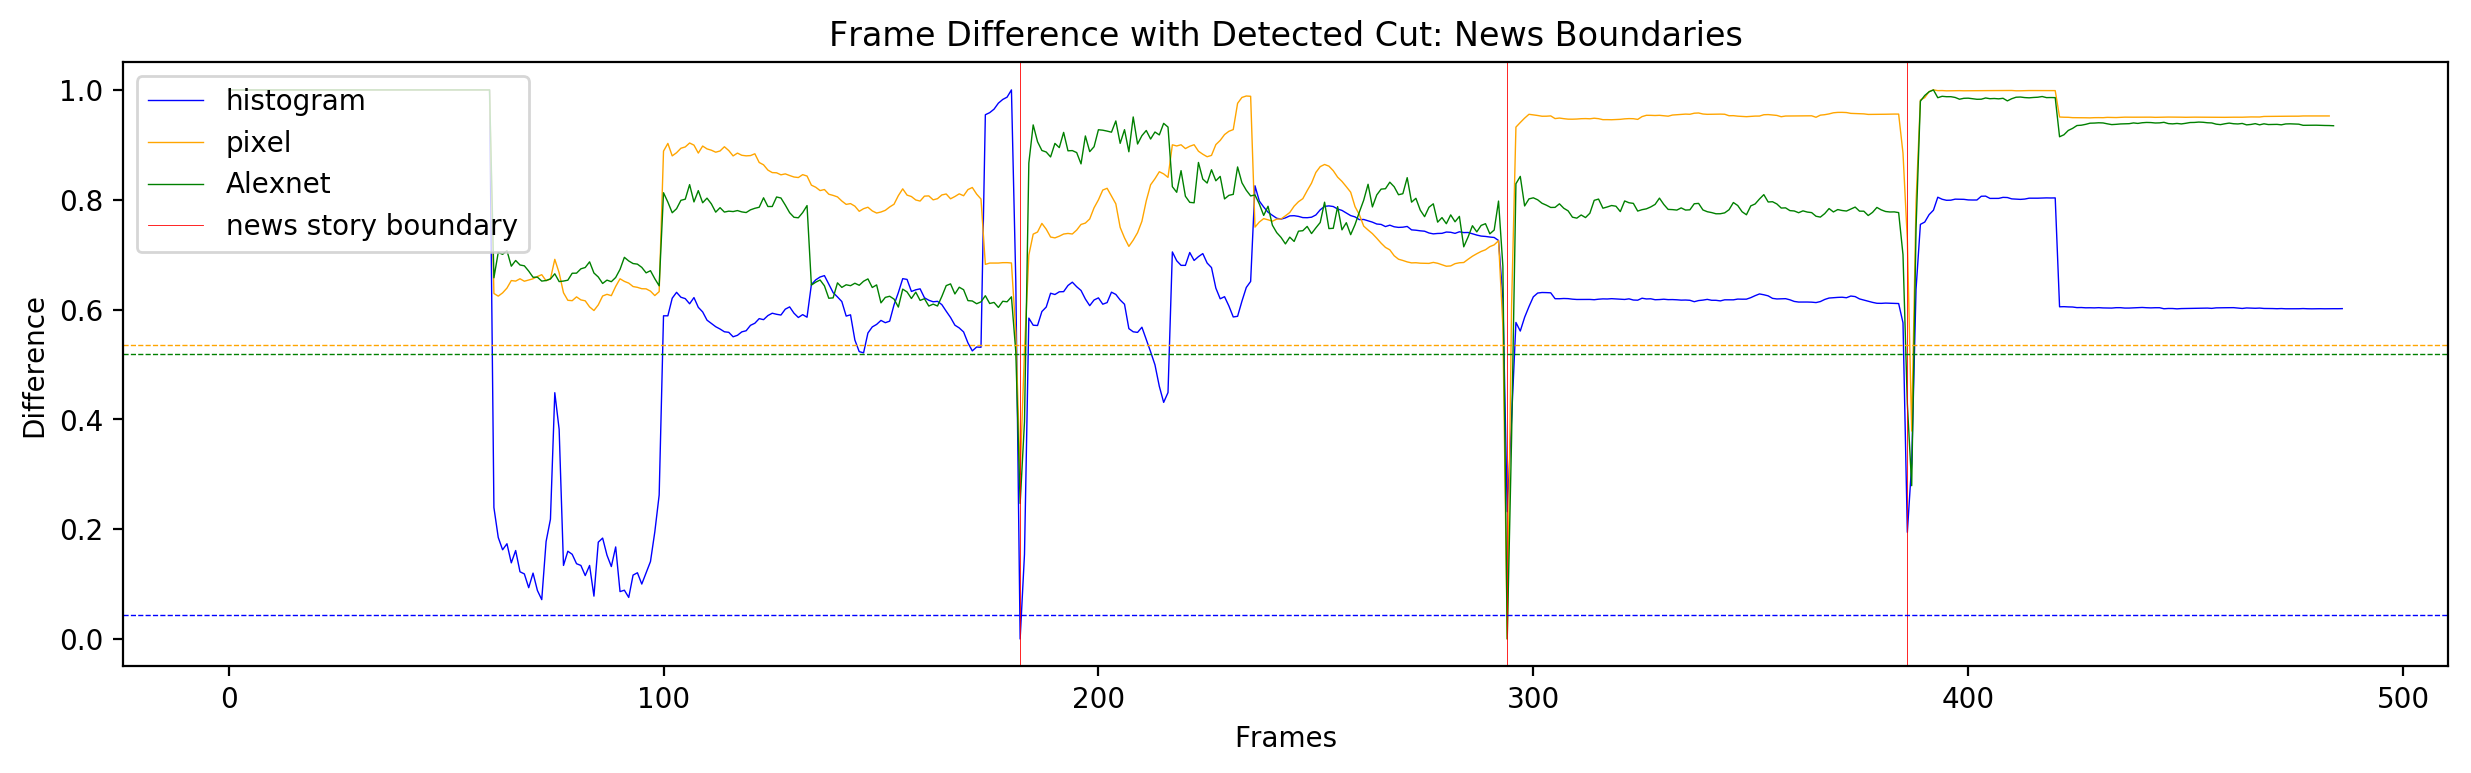

In [24]:
# reporterhist[0] = diff, reporterhist[1] = tcut
plt.figure(dpi =200, figsize=(15, 4))
plt.title('Frame Difference with Detected Cut: News Boundaries')
plt.xlabel('Frames')
plt.ylabel('Difference')

plt.plot(np.concatenate([np.ones(reporterhist2[2]), fr_diffhist2[0]]), lw = 0.5, color = 'blue', label = 'histogram')
plt.plot(np.concatenate([np.ones(reporterpix2[2]), fr_diffpix2[0]]), lw = 0.5, color = 'orange', label = 'pixel')
plt.plot(np.concatenate([np.ones(reporternet2[2]), fr_diffnet2[0]]), lw = 0.5, color = 'green', label = 'Alexnet')
plt.axvline(121+reporternet2[2], lw = 0.3, color = 'red', label = 'news story boundary')
plt.legend(loc='upper left')

plt.axvline(233+reporternet2[2], lw = 0.3, color = 'red')
plt.axvline(325+reporternet2[2], lw = 0.3, color = 'red')

plt.axhline(fr_diffhist2[1], lw = 0.5, color = 'blue', ls = '--')
plt.axhline(fr_diffpix2[1], lw = 0.5, color = 'orange', ls = '--')
plt.axhline(fr_diffnet2[1], lw = 0.5, color = 'green', ls = '--')

plt.savefig('boundaries-diff')
plt.show()

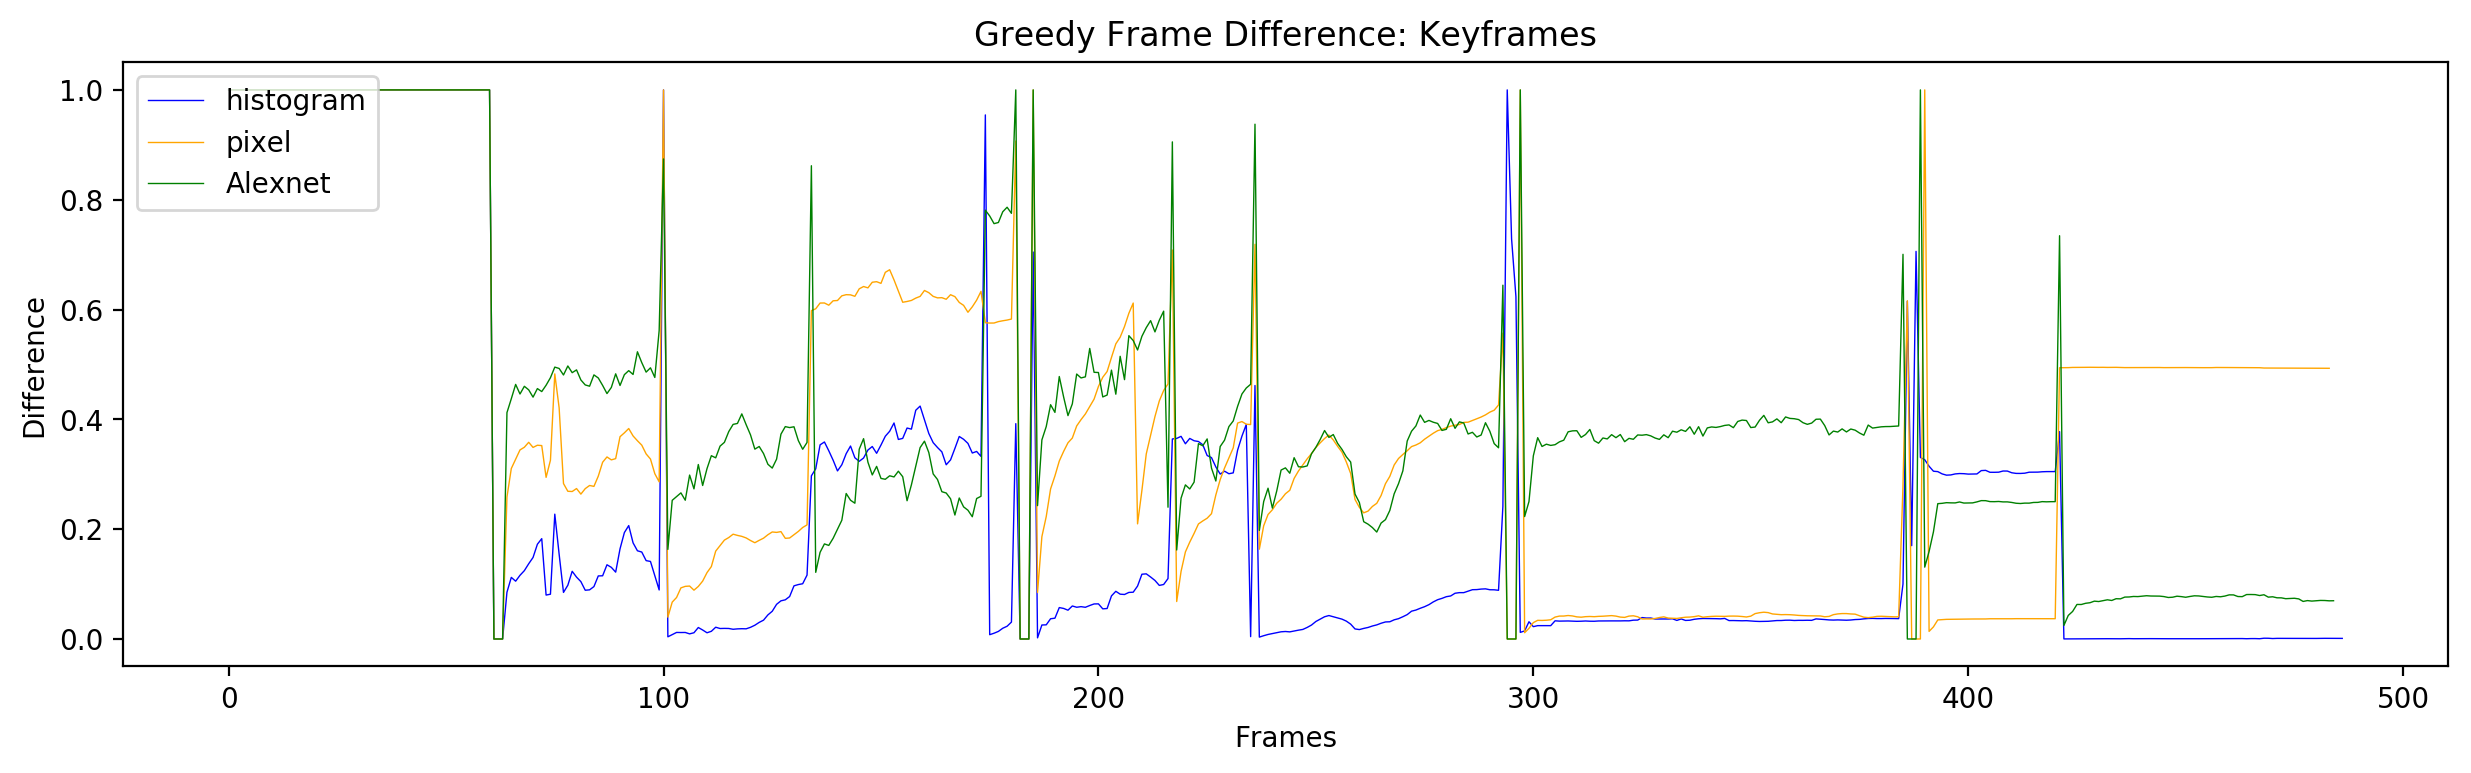

In [25]:
# reporterhist[0] = diff, reporterhist[1] = tcut
plt.figure(dpi =200, figsize=(15, 4))
plt.title('Greedy Frame Difference: Keyframes')
plt.xlabel('Frames')
plt.ylabel('Difference')

plt.plot(np.concatenate([np.ones(reporterhist2[2]), np.concatenate(differenceshist2[0::], axis=None)]), lw = 0.5, color = 'blue', label = 'histogram')
plt.plot(np.concatenate([np.ones(reporterpix2[2]), np.concatenate(differencespix2[0::], axis=None)]), lw = 0.5, color = 'orange', label = 'pixel')
plt.plot(np.concatenate([np.ones(reporternet2[2]), np.concatenate(differencesnet2[0::], axis=None)]), lw = 0.5, color = 'green', label = 'Alexnet')
plt.legend(loc='upper left')

plt.savefig('september03-keyframe-diff')
plt.show()

In [ ]:
image_tmpl = 'image-{:03d}.png'
def show_sumfrs(results, image_tmpl):
    video_name = results[0].strip()
    directory = '../data/' + video_name + '/'
    plt.figure(figsize=(20,20))
    columns = 5
    i = 0
#     print(directory)
    for nr in results[1]:
        image = pre._load_image(directory, image_tmpl, int(nr), 'RGB')
        plt.subplot((len(results[1])) / columns + 1, columns, i + 1)
        plt.title(nr, fontsize=12)
        plt.imshow(image)#, cmap=plt.cm.gray, vmin=0, vmax=1)
        i = i+1
    plt.tight_layout()
    plt.savefig('keyframes60/' + video_name)
    
import re
def read_results(file):
    with open(file, 'r') as f:
        all_videos = f.readlines()
        video_res = []

        for result in all_videos:
            summary = result.strip().split("; ")
            video_name = summary[0]
            sum_frames = summary[1::][0]
            junkers = re.compile('[[" \]]')
            result2 = junkers.sub('', sum_frames).split(',')
            for fr in result2:
                if fr == '':
                    result2.remove('')
            video_res.append([video_name, result2])
        return video_res

In [ ]:
video_res400 = read_results('keyframes-alexnet-40-0.txt')
print(video_res400)
for res in video_res400:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res401 = read_results('keyframes-alexnet-40-1.txt')
print(video_res401)
for res in video_res401:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res402 = read_results('keyframes-alexnet-40-2.txt')
print(video_res402)
for res in video_res402:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res403 = read_results('keyframes-alexnet-40-3.txt')
print(video_res403)
for res in video_res403:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res404 = read_results('keyframes-alexnet-40-4.txt')
print(video_res404)
for res in video_res404:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res500 = read_results('keyframes-alexnet-50-0.txt')
print(video_res500)
for res in video_res500:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res501 = read_results('keyframes-alexnet-50-1.txt')
print(video_res501)
for res in video_res501:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res502 = read_results('keyframes-alexnet-50-2.txt')
print(video_res502)
for res in video_res502:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res503 = read_results('keyframes-alexnet-50-3.txt')
print(video_res503)
for res in video_res503:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res504 = read_results('keyframes-alexnet-50-4.txt')
print(video_res504)
for res in video_res504:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res604 = read_results('keyframes-alexnet-60-4.txt')
print(video_res604)
for res in video_res604:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res603 = read_results('keyframes-alexnet-60-3.txt')
print(video_res603)
for res in video_res603:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res602 = read_results('keyframes-alexnet-60-2.txt')
print(video_res602)
for res in video_res602:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res601 = read_results('keyframes-alexnet-60-1.txt')
print(video_res601)
for res in video_res601:
    show_sumfrs(res, image_tmpl)

In [ ]:
video_res600 = read_results('keyframes-alexnet-60-0.txt')
print(video_res600)
for res in video_res600:
    show_sumfrs(res, image_tmpl)

In [ ]:
A = np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
print(A)
np.concatenate(A[0::], axis=None)

reporter-comp:  668543.4207541399
end logo-comp:  553411.1143362158
comp-comp:  0.0
reporter-comp:  2688000.0
endlogo-comp:  2688000.0
comp-comp:  2688000.0
---- REVERSED ----
reporter-comp:  668543.4207541399
end logo-comp:  553411.1143362158
comp-comp:  0.0
reporter-comp:  786223.153139801
endlogo-comp:  0.0
comp-comp:  0.0
[668543.42075414 553411.11433622      0.        ]
[1.         0.82778634 0.        ]


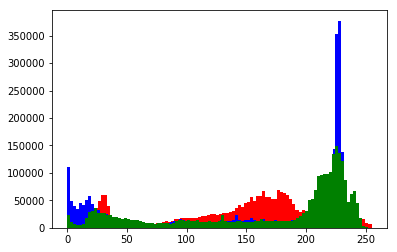

In [10]:
def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
    for (a, b) in zip(histA, histB)])
 
    # return the chi-squared distance
    return d

color = 'RGB'

reporter_rgb = pre.process_single_fr(REPORTER_FILE, color) #load reporter boundary frame
reporter_method = plt.hist(reporter_rgb.flatten(), 100, color = 'red')
end_logo_rgb = pre.process_single_fr(END_LOGO_FILE, color) #load end logo boundary frame
end_logo_method = plt.hist(end_logo_rgb.flatten(), 100, color = 'blue')
comp_rgb = pre.process_single_fr(BOUNDARY_FILE, color) #load comparison frame
comp_method = plt.hist(comp_rgb.flatten(), 100, color = 'green')


d = chi2_distance(reporter_method[0], comp_method[0])
print('reporter-comp: ', d)
e = chi2_distance(end_logo_method[0], comp_method[0])
print('end logo-comp: ', e)
f = chi2_distance(comp_method[0], comp_method[0])
print('comp-comp: ', f)

g = np.sum(np.absolute(reporter_method[0], comp_method[0]))
h = np.sum(np.absolute(end_logo_method[0], comp_method[0]))
i = np.sum(np.absolute(comp_method[0], comp_method[0]))

print('reporter-comp: ', g)
print('endlogo-comp: ', h)
print('comp-comp: ', i)

print('---- REVERSED ----')
j = chi2_distance(comp_method[0], reporter_method[0])
print('reporter-comp: ', d)
k = chi2_distance(comp_method[0], end_logo_method[0])
print('end logo-comp: ', e)
l = chi2_distance(comp_method[0], comp_method[0])
print('comp-comp: ', f)

print('reporter-comp: ', j)
print('endlogo-comp: ', k)
print('comp-comp: ', l)


results = np.array([d, e, f])
print(results)
results *= 1.0/results.max() 
print(results)

In [ ]:
#plot difference reporter
plt.plot(differencespix)
plt.title('Frame Difference with Detected Cut : Boundaries')
plt.xlabel('Frames')
plt.ylabel('Difference')
plt.show()

In [ ]:
differencespix *= 1.0/differencespix.max() 
#plot difference reporter
plt.plot(differencespix)
plt.title('Frame Difference with Detected Cut : Boundaries')
plt.xlabel('Frames')
plt.ylabel('Difference')
plt.show()

In [ ]:
differences = np.concatenate(differencesnet[0::])
#plot difference reporter
plt.plot(differences)
plt.title('Frame Difference with Detected Cut : Boundaries')
plt.xlabel('Frames')
plt.ylabel('Difference')
plt.show()

In [ ]:
#plot difference reporter
differences *= 1.0/differences.max() 
plt.plot(differences)
plt.title('Frame Difference with Detected Cut : Boundaries')
plt.xlabel('Frames')
plt.ylabel('Difference')
plt.show()

In [8]:
45*10**6

45000000